# Decision Trees, Random Forests, and Gradient Boosted Decision Trees

Learning Objectives:
* Students will learn what a decision tree is and how it applies to classification and regression.
* Students will understand how a combination of decision trees as a random forest improves models.
* Students will interactively learn about and apply gradient boosted decision trees.

Readings before class:
* Jake VanderPlas.  [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/):
  * [Chapter 5 - Only read section "In Depth: Decision Trees and Random Forests"](https://jakevdp.github.io/PythonDataScienceHandbook/) _Below, we summarize this reading and further illustrate it.  Spend focused attention here._
* Alex Rogozhnikov’s beautiful demonstration: [Gradient Boosting Explained](https://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)  _Not only is this a great interactive visual illustration of concepts, but it also has embedded explanations.  Don't skip over the underlined explanation links ("how is the tree built?", "what is gradient boosting?", "interesting things") - when clicked on, they reveal further text and explanations._

In class:
* We will work together on the exercises in section "In Class".

Homework after class:
* Complete the section labeled "Homework" below before the next class when it will be collected.


# Decision Trees

Perhaps you have played the number guessing game as a child. "I'm thinking of a number from 1 to 100."  "50?"  "Lower."  "25?"  "Higher." ...

It's unlikely that you've ever had a player guess like this: "I'm thinking of a number from 1 to 100."  "1?"  "Higher."  "2?"  "Higher." "3?"  "Higher." "4?"  "Higher!" ...

Why are the first and second dialogs, a good and bad way to play, respectively?  In the first case, we are gaining the most information, dividing outcomes as evenly as possible.  In the second case, we merely eliminate one more possibility each time.

A decision tree is, as the name implies, a tree of decisions.  Let us look at Wikipedia's simple Kaggle Titanic dataset decision tree:

![Wikipedia's simple Kaggle Titanic dataset decision tree](https://upload.wikimedia.org/wikipedia/commons/thumb/e/eb/Decision_Tree.jpg/440px-Decision_Tree.jpg)

Each decision node seeks to divide data into similar instances until we have enough information to make a helpful prediction at the terminal nodes, the tips of branches.  Rules vary for when a node terminates instead of branching further.  One method might continue dividing until variance among training instances that travel the same branches falls below a threshold.  Other methods are depth-limited, always terminating branches at a given depth limit.  Regardless, the core idea is the same: Form question nodes that partition the data so that variance in predictions is reduced, and at terminal nodes, make a prediction (classification or regression).

Let us begin by generating data as we saw in the VanderPlas text:


In [1]:
# Imports

import math
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import random
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb


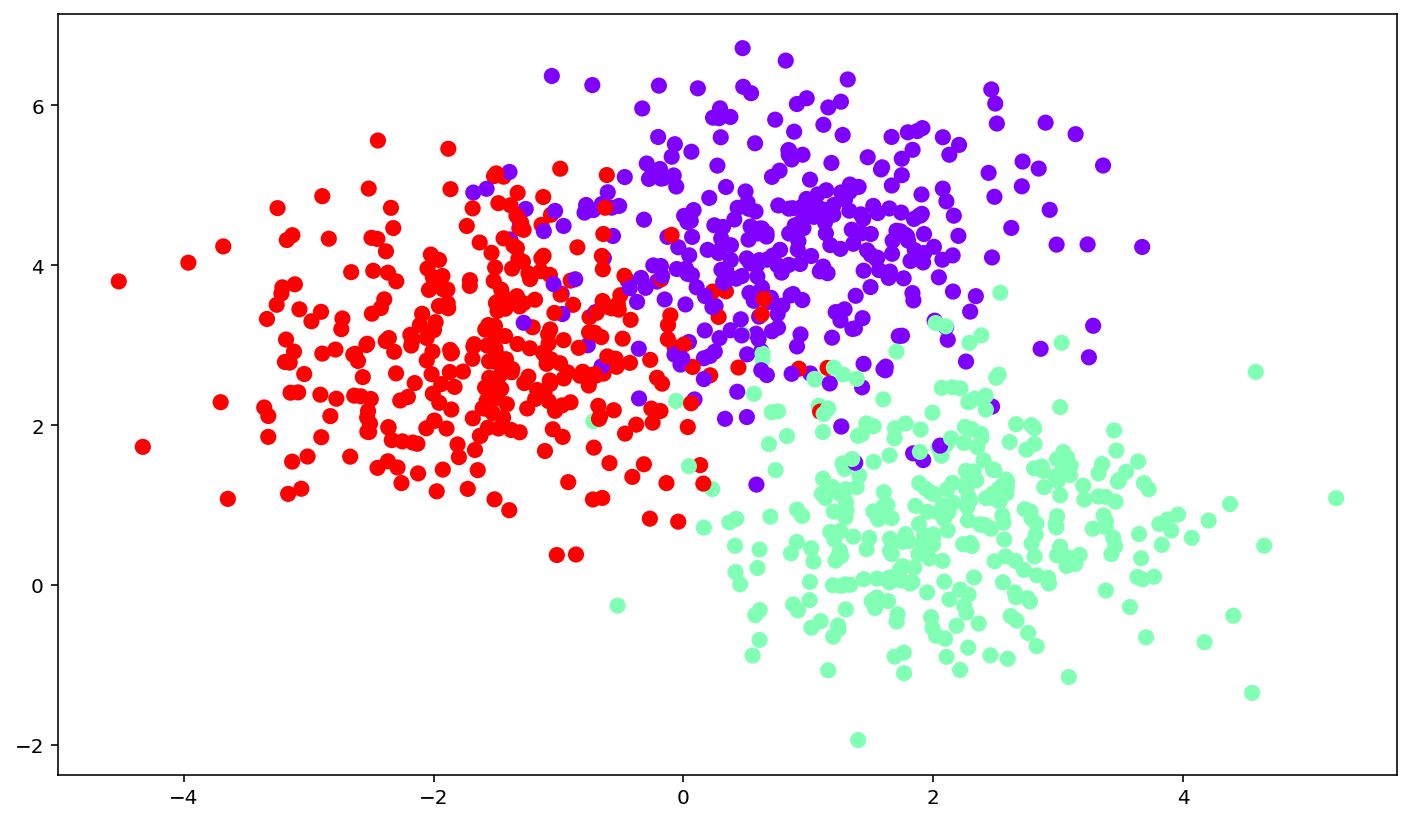

In [2]:
my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)

# We generate 1000 clustered 2D data points sampled from 3 normally-distributed clusters 
#   with each cluster representing a different class.
X, y = make_blobs(n_samples=1000, centers=3,
                  random_state=my_seed, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');



Decision Tree Model with Training Data:


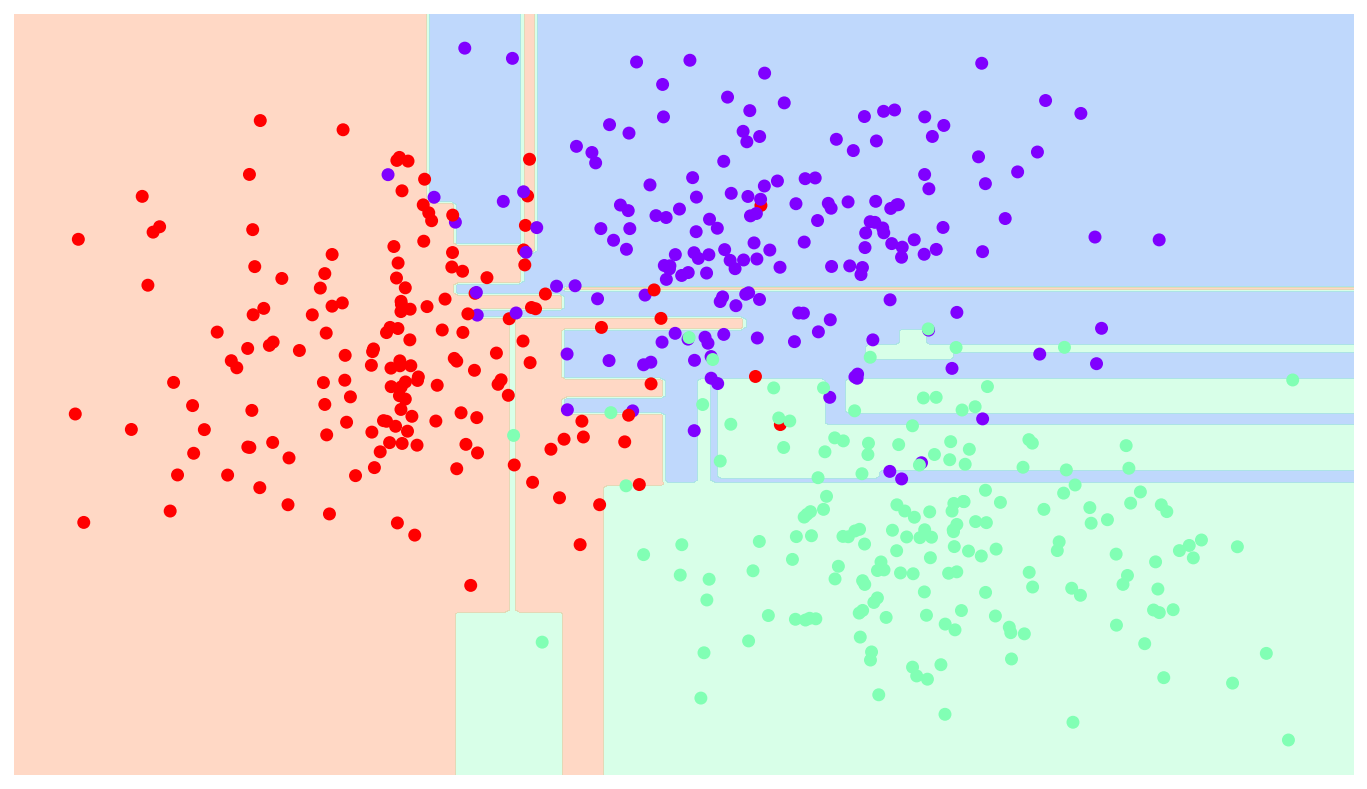

Class 0 training accuracy:  1.0
Class 1 training accuracy:  1.0
Class 2 training accuracy:  1.0
Decision Tree Model with Testing Data:


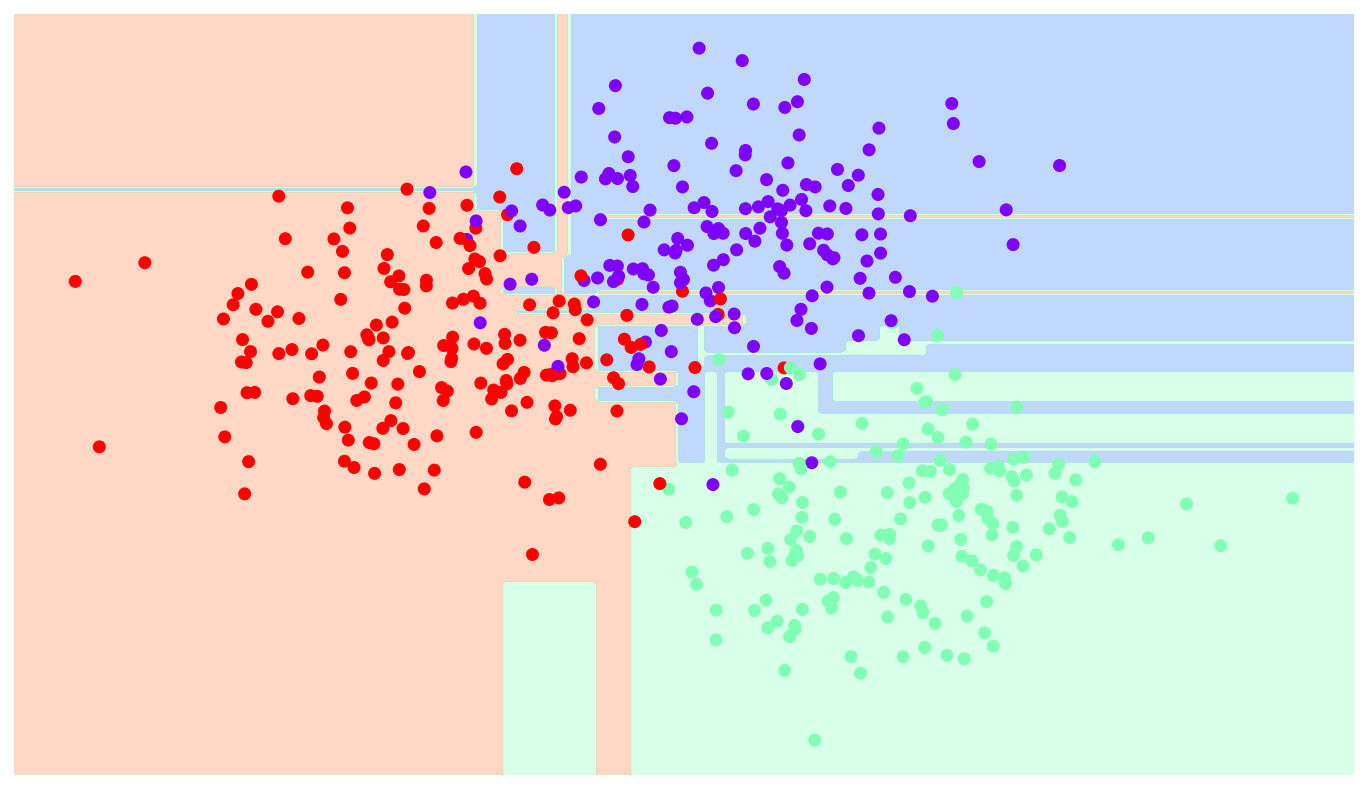

Class 0 testing accuracy:  0.898


Class 1 testing accuracy:  0.956
Class 2 testing accuracy:  0.926


In [3]:
# As before, we will split our datasets into training and testing datasets.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=my_seed, shuffle=True)

# Unlike the text, we train our decision tree with just the training dataset.
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

# We can visualize the model by using VanderPlas' visualization code
# modified to _assume the model is already fit_:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()

    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, #clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

print("\nDecision Tree Model with Training Data:")
visualize_classifier(model, X_train, y_train, ax = plt.gca())
plt.show()

# Our accuracy numbers will look great if we compute accuracy using the training set, which is # why we do our testing against held-out data to watch for overfitting.
# Accuracy score is for binary True/False or 1/0, so we'll need to test it for each class:
y_predict = model.predict(X_train)
for c in range(3):
    print('Class', c, 'training accuracy: ', accuracy_score(y_train == c, y_predict == c))

# Next we visualize how the classifier works (or doesn't work) with the testing data:
print("Decision Tree Model with Testing Data:")
visualize_classifier(model, X_test, y_test, ax = plt.gca())
plt.show()

# We can test this against our held-out testing dataset to see how the classifier generalizes for accuracy.  
y_predict = model.predict(X_test)
for c in range(3):
    print('Class', c, 'testing accuracy: ', accuracy_score(y_test == c, y_predict == c))


(The classification areas will look slightly different because the bounds of the training and testing dataset are slightly different, and there are some very thin sections that will show or not depending on the bounds at this resolution.)

These are some rather odd decision boundaries.  Overfitting is a characteristic of decision tree that branch until subsets of points are "pure", i.e. having the same classification or regression value.  One way to reduce overfitting is to limit the depth of a tree.  Here is the effect of limiting the tree to depth 3.


Decision Tree Model (depth limit = 3) with Training Data:


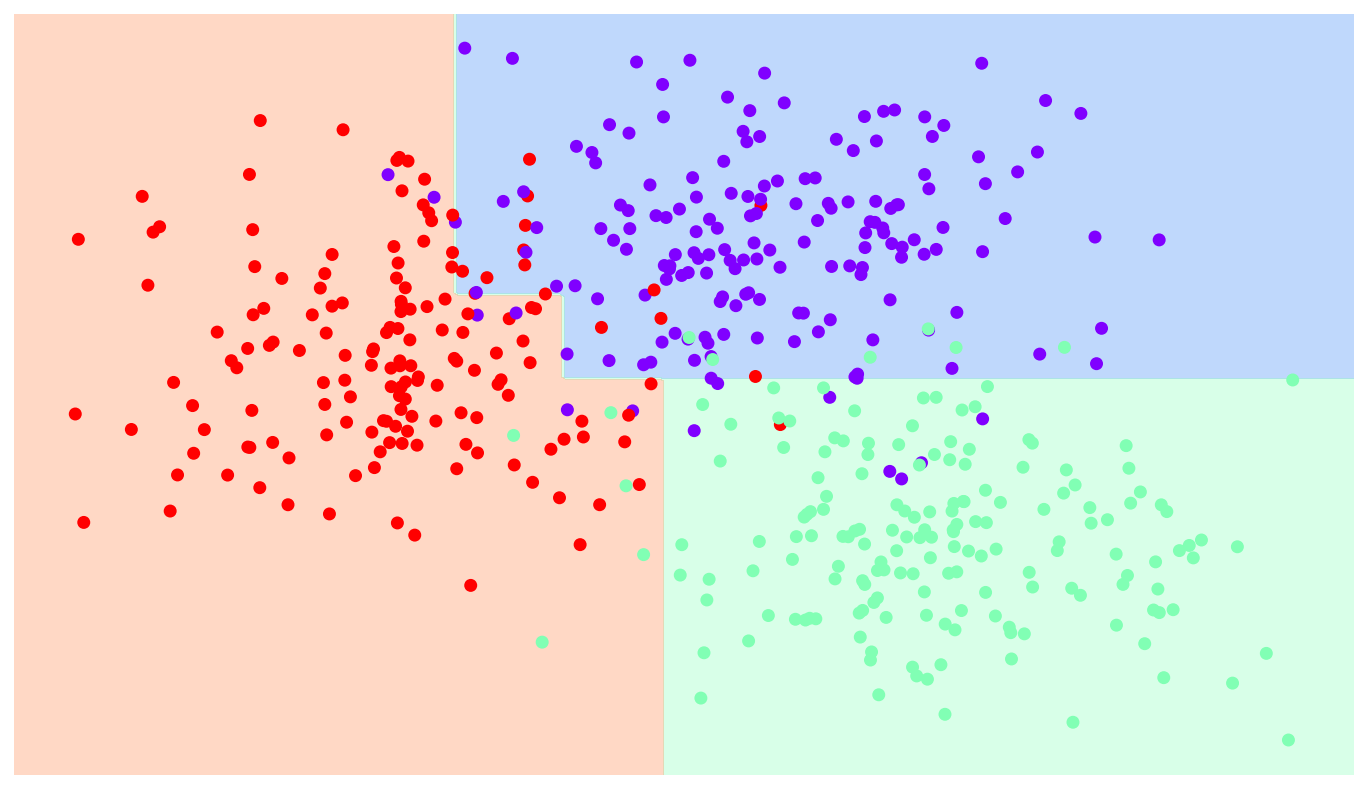

Class 0 training accuracy:  0.938
Class 1 training accuracy:  0.962
Class 2 training accuracy:  0.952

Decision Tree Model (depth limit = 3) with Testing Data:


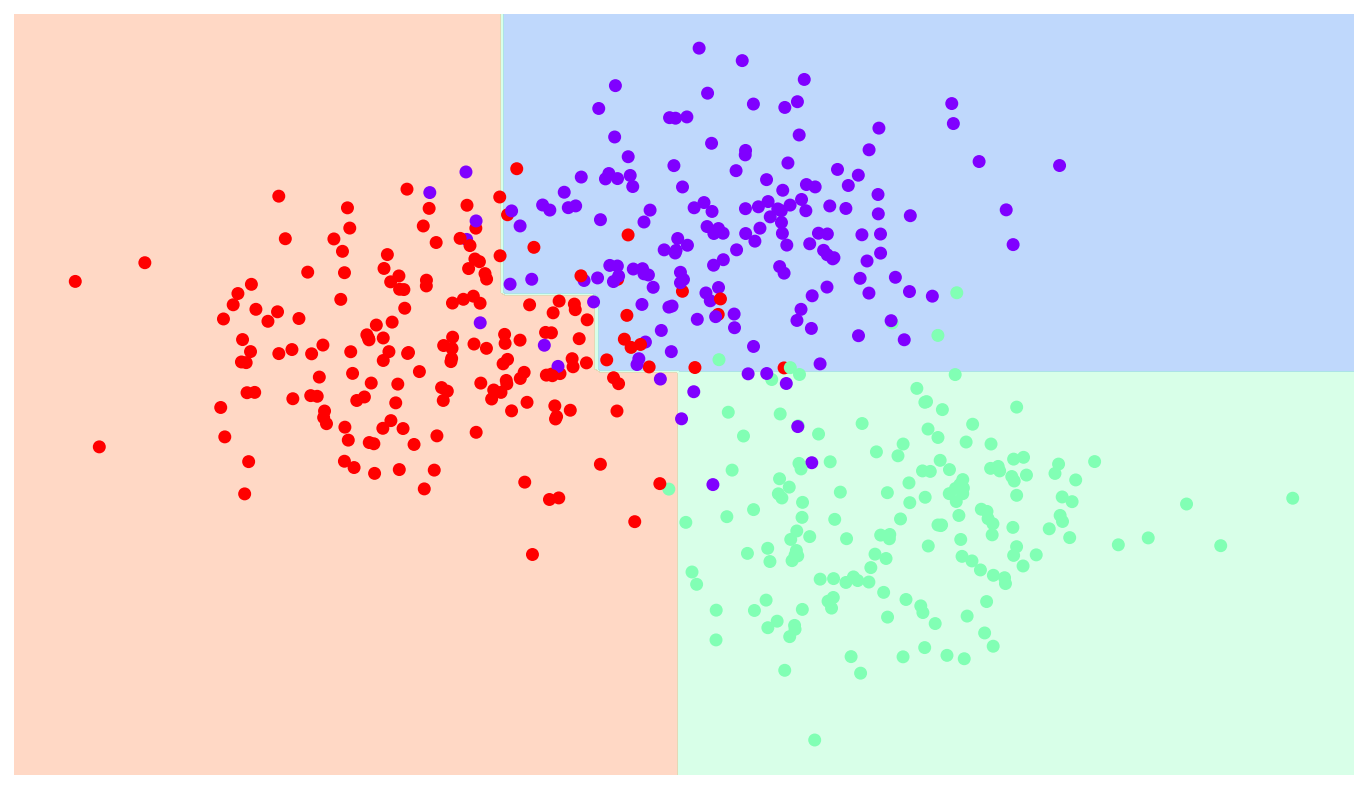

Class 0 testing accuracy:  0.92
Class 1 testing accuracy:  0.972
Class 2 testing accuracy:  0.944


In [4]:
model = DecisionTreeClassifier(max_depth=3)
model.fit(X_train, y_train)

print("Decision Tree Model (depth limit = 3) with Training Data:")
visualize_classifier(model, X_train, y_train, ax = plt.gca())
plt.show()
y_predict = model.predict(X_train)
for c in range(3):
    print('Class', c, 'training accuracy: ', accuracy_score(y_train == c, y_predict == c))

print("\nDecision Tree Model (depth limit = 3) with Testing Data:")
visualize_classifier(model, X_test, y_test, ax = plt.gca())
plt.show()
y_predict = model.predict(X_test)
for c in range(3):
    print('Class', c, 'testing accuracy: ', accuracy_score(y_test == c, y_predict == c))

This is better, but the nature of the decision boundaries makes this model "blocky", strictly dividing along single dimension value boundaries.  There are a number of ways we can improve this.  One way is to create a large number of _randomized_ overfitting decision trees and have them "vote" for classifications.  (In regression applications, we would average predicted values.)  How are the trees randomized?  We can randomize the input variable choices for the decisions at each node.

This is the beginning of a theme you will see recur in many predictive approaches: An ensemble of imperfect predictors can together yield an improved predictor.  Think of this as a "wisdom of the masses" analogue.

In [0]:
model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(X_train, y_train)

print("Random Forest Model with Training Data:")
visualize_classifier(model, X_train, y_train, ax = plt.gca())
plt.show()
y_predict = model.predict(X_train)
for c in range(3):
    print('Class', c, 'training accuracy: ', accuracy_score(y_train == c, y_predict == c))

print("\nRandom Forest Model with Testing Data:")
visualize_classifier(model, X_test, y_test, ax = plt.gca())
plt.show()
y_predict = model.predict(X_test)
for c in range(3):
    print('Class', c, 'testing accuracy: ', accuracy_score(y_test == c, y_predict == c))

We can also build each randomized tree based on different subsets of the training data (e.g. a random 80% of the training set) as shown below:

In [0]:
model = RandomForestClassifier(n_estimators=100, random_state=0, max_samples=0.8)
model.fit(X_train, y_train)

print("Random Forest Model (80% samples) with Training Data:")
visualize_classifier(model, X_train, y_train, ax = plt.gca())
plt.show()
y_predict = model.predict(X_train)
for c in range(3):
    print('Class', c, 'training accuracy: ', accuracy_score(y_train == c, y_predict == c))

print("\nRandom Forest Model (80% samples) with Testing Data:")
visualize_classifier(model, X_test, y_test, ax = plt.gca())
plt.show()
y_predict = model.predict(X_test)
for c in range(3):
    print('Class', c, 'testing accuracy: ', accuracy_score(y_test == c, y_predict == c))

To see more detail of misclassifications, we can also show a _confusion matrix_ where each row is the known class and each column is the predicted class.  This shows us that classes 0 and 2 are most often being confused with each other.

In [0]:
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues);


Perhaps the most popular family of decision-tree-related methods are _gradient-boosted machines_, especially _gradient-boosted decision trees_ and _gradient-boosted regression trees_.  The basic idea of these is that a base predicting is made, and successive trees are build to predict and correct error of the weighted combination of previous models.

[XGBoost](https://xgboost.readthedocs.io/en/latest/) is the most popular of these.

> "Among the 29 challenge winning solutions published at Kaggle’s blog during 2015, 17 solutions [~59%] used XGBoost. Among these solutions, eight [~28%] solely used XGBoost to train the model, while most others combined XGBoost with neural nets in ensembles." - Tianqi Chen, Carlos Guestrin. [“XGBoost: A Scalable Tree Boosting System”](https://arxiv.org/pdf/1603.02754.pdf)


In [0]:
model = xgb.XGBClassifier(
    gamma=1,
    learning_rate=0.01,
    max_depth=3,
    n_estimators=100,
    subsample=0.8,
    random_state=my_seed
)

model.fit(X_train, y_train)

print("XGBoost Model (80% samples) with Testing Data:")
visualize_classifier(model, X_test, y_test, ax = plt.gca())
plt.show()
y_predict = model.predict(X_test)
for c in range(3):
    print('Class', c, 'testing accuracy: ', accuracy_score(y_test == c, y_predict == c))

plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues);


While our XGBoost performance slightly better than the best previous performance, we can see that the classification boundaries are the simplest and cleanest yet.

## Regression Trees

Decision trees are usually classification trees that predict categorical values, i.e. discrete unordered values.
Decision trees that predict ordered continuous values (typically real numbers) are called _regression trees_.  To illustrate, we will load our previous degree-4 polynomial data and show regression performance with regression analogues of the models above.  

You will see that plain decision tree regression badly overfits, yet has a high $R^2$ score.  For regressions, it is common to use _mean squared error_ (MSE), i.e. the average squared distance of a prediction from the true value, as the error measure.  Whereas a higher $R^2$ score is better and a perfect $R^2$ score is 1, a lower MSE is better and a perfect MSE is 0.

In [0]:
df = pd.read_csv('http://cs.gettysburg.edu/~tneller/ds256/data/hw6/hw6-1.csv', index_col='id')

X = df[['x']]  # select input(s)
y = df[['y']]  # select output

# As before, we will split our datasets into training and testing datasets.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=my_seed, shuffle=True)

# Decision Tree Regression
print('Decision Tree Regression')

model = DecisionTreeRegressor()
model.fit(X_train, y_train)  # perform linear regression of output onto inputs

Xfit = pd.DataFrame()
Xfit['x'] = np.linspace(start=X['x'].min(), stop=X['x'].max(), num=1000)  # 1000 linearly spaces points from the min to the max of x
yfit = model.predict(Xfit)  # predict y's from the linearly spaced x data
plt.scatter(X['x'], y)  # scatter plot of original data
plt.plot(Xfit['x'], yfit, color='orange');  # line plot showing fit of learned quartic function
plt.show()

print('R^2 Score:', model.score(X_test, y_test))
print('Mean squared error (MSE):', mean_squared_error(y_test, model.predict(X_test)))

# Random Forest Regression
print('\nRandom Forest Regression')

model = RandomForestRegressor()
model.fit(X_train, y_train.values.ravel())

Xfit = pd.DataFrame()
Xfit['x'] = np.linspace(start=X['x'].min(), stop=X['x'].max(), num=1000)  # 1000 linearly spaces points from the min to the max of x
yfit = model.predict(Xfit)  # predict y's from the linearly spaced x data
plt.scatter(X['x'], y)  # scatter plot of original data
plt.plot(Xfit['x'], yfit, color='orange');  # line plot showing fit of learned quartic function
plt.show()

print('R^2 Score:', model.score(X_test, y_test))
print('Mean squared error (MSE):', mean_squared_error(y_test, model.predict(X_test)))

# XGBoost Regression
print('\nXGBoost Regression')

model = xgb.XGBRegressor()
model.fit(X_train, y_train.values.ravel())

Xfit = pd.DataFrame()
Xfit['x'] = np.linspace(start=X['x'].min(), stop=X['x'].max(), num=1000)  # 1000 linearly spaces points from the min to the max of x
yfit = model.predict(Xfit)  # predict y's from the linearly spaced x data
plt.scatter(X['x'], y)  # scatter plot of original data
plt.plot(Xfit['x'], yfit, color='orange');  # line plot showing fit of learned quartic function
plt.show()

print('Mean squared error (MSE):', mean_squared_error(y_test, model.predict(X_test)))

print('\nXGBoost Regression with Parameter Tuning')

# I have commented out the parameter tuning here to save you the intensive computation. 
# Approach adapted from: https://www.kaggle.com/pablocastilla/predict-house-prices-with-xgboost-regression

# parameters_for_testing = {
#    'gamma':[0,0.03,0.1,0.3],
#    'min_child_weight':[1.5,6,10],
#    'learning_rate':[0.1,0.07],
#    'max_depth':[3,5],
#    'n_estimators':[100],
#    'reg_alpha':[1e-5, 1e-2,  0.75],
#    'reg_lambda':[1e-5, 1e-2, 0.45],
#    'subsample':[0.6,0.95]
# }

# model = xgb.XGBRegressor()

# grid_search = GridSearchCV(model, param_grid=parameters_for_testing, n_jobs=6, verbose=10, scoring='neg_mean_squared_error')
# grid_search.fit(X_train,y_train)
# print('Best parameters:')
# print(grid_search.best_params_)
# print('Best score:')
# print(grid_search.best_score_)


# Best parameters:
# {'gamma': 0, 'learning_rate': 0.07, 'max_depth': 3, 'min_child_weight': 1.5, 'n_estimators': 100, 'reg_alpha': 1e-05, 'reg_lambda': 1e-05, 'subsample': 0.6}
# Best score:
# -27185.70732805021


model = xgb.XGBRegressor(gamma=0, learning_rate=0.07, max_depth=3, min_child_weight=1.5, n_estimators=100, reg_alpha=1e-5, subsample=0.6)
model.fit(X_train, y_train.values.ravel())

Xfit = pd.DataFrame()
Xfit['x'] = np.linspace(start=X['x'].min(), stop=X['x'].max(), num=1000)  # 1000 linearly spaces points from the min to the max of x
yfit = model.predict(Xfit)  # predict y's from the linearly spaced x data
plt.scatter(X['x'], y)  # scatter plot of original data
plt.plot(Xfit['x'], yfit, color='orange');  # line plot showing fit of learned quartic function
plt.show()

print('Mean squared error (MSE):', mean_squared_error(y_test, model.predict(X_test)))


print('\nPolynomial Regression using Linear Regression')

model = LinearRegression()
dfPoly = df.copy()
dfPoly['xpow2'] = dfPoly['x'].pow(2)
dfPoly['xpow3'] = dfPoly['x'].pow(3)
dfPoly['xpow4'] = dfPoly['x'].pow(4)
X = dfPoly[['x', 'xpow2', 'xpow3', 'xpow4']]  # select input(s)
y = dfPoly[['y']]  # select output

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=my_seed, shuffle=True)
model.fit(X_train, y_train)

Xfit = pd.DataFrame()
Xfit['x'] = np.linspace(start=X['x'].min(), stop=X['x'].max(), num=1000)  # 1000 linearly spaces points from the min to the max of x
Xfit['xpow2'] = Xfit['x'].pow(2)
Xfit['xpow3'] = Xfit['x'].pow(3)
Xfit['xpow4'] = Xfit['x'].pow(4)
yfit = model.predict(Xfit)  # predict y's from the linearly spaced x data
plt.scatter(X['x'], y)  # scatter plot of original data
plt.plot(Xfit['x'], yfit, color='orange');  # line plot showing fit of learned quartic function
plt.show()

print('Mean squared error (MSE):', mean_squared_error(y_test, model.predict(X_test)))


Far and away, our previous polynomial regression works best here, but one must consider:

1. If we know the underlying mathematical model for the data, it is easy to choose a simple, suitable statistical model.
2. Real-world data isn't often so simple as a polynomial with noise, and in many cases, one prefers a tool that "just works" decently for a wide variety of problems.

The superiority of directly modeling a functional form with know plus noise isn't a summary judgment against these overfitting tree-based regressions.  Rather, it's a wonder that ensembles of tree work as well as they do for a variety of classification and regression tasks!


# In Class

For all in-class exercises, perform a 50/50 training/testing data split.  Train models on the training data.  Test models on the testing data.

## Classification

For the following classification data:
* Compute a 50/50 training/testing data split.
* Compute a classification model with the training data.
* Visualize the classification model with a scatterplot of testing data.
* Print the testing data accuracy score for each class.
* Plot the confusion matrix.

Do this for each of the following classification models:
* Decision Tree
* Random Forest
* XGBoost Classifier
* $k$-Nearest Neighbor with best $k$


In [0]:
my_seed = 7
random.seed(my_seed)
np.random.seed(my_seed)
num_classes = 5

# We generate 2000 clustered 2D data points sampled from 5 normally-distributed clusters
#   with each cluster representing a different class.
X, y = make_blobs(n_samples=2000, centers=num_classes,
                  random_state=my_seed, cluster_std=2.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');



## Regression

For the following regression data:
* Compute a 50/50 training/testing data split.
* Compute a regression model with the training data.
* Visualize the regression model curve with a scatterplot of testing data.
* Print the MSE for the testing data.

Do this for each of the following regression models:
* Regression Tree
* Random Forest Regression
* XGBoost Regressor (untuned)
* $k$-Nearest Neighbor Regression with $k=3$ ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html))


In [0]:
random.seed(42)
np.random.seed(42)
x_names = ['x']
df = pd.DataFrame(np.random.uniform(low=-5, high=5, size=(1000, 1)), columns=x_names)
df['y'] = df['x'].map(lambda x: 42 + 20 * math.sin(x) + x * x + (-10 if round(x) % 2 == 0 else 0) + np.random.normal(scale=1))
plt.scatter(df['x'], df['y'])  # scatter plot of original data



## Homework


**Exercise 1:** Complete the in-class exercises if you haven't already.

**Exercise 2:** Model and classify the data of [hw12-1.csv](http://cs.gettysburg.edu/~tneller/ds256/data/hw12/hw12-1.csv) with all of the steps and models of your in-class classification work.  _However_, you must first preprocess and normalize your data.

Tip: If you have problems with an error "TypeError: '(slice(None, None, None), 0)' is an invalid key", use the following when you split your data:

```X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, train_size=0.5, random_state=my_seed, shuffle=True)```

More on this in chapters on ```numpy``` and ```pandas```.


**Exercise 3:** Model and regress the data of [hw12-2.csv](http://cs.gettysburg.edu/~tneller/ds256/data/hw12/hw12-2.csv) with all of the steps and models of your in-class regression work.

(end of homework)